이것은 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 책의 노트북이다. 가독성을 위해 실행 가능한 코드 블록과 섹션 제목만 포함하고 책의 다른 모든 텍스트 단락, 그림 및 의사 코드는 생략한다.

**무슨 일이 일어나고 있는지 확인하고 싶다면 책과 함께 노트북을 사용하는 것을 권장한다.**

이 노트북은 TensorFlow 2.6 기반이다. (옮긴이: 버전 2.10.0, 애플 실리콘 M1 으로 테스트)

# 시계열에 대한 딥러닝

## 시계열 작업의 상이한 종류

## 온도 예측 예제

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-11-16 18:47:27--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.141.96
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.141.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: 'jena_climate_2009_2016.csv.zip'

jena_climate_2009_2 100%[===================>]  12.94M  3.61MB/s    in 3.6s    

2022-11-16 18:47:32 (3.61 MB/s) - 'jena_climate_2009_2016.csv.zip' saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Jena 날씨 데이터 세트의 데이터 검사**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**데이터 구문 분석**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**온도 시계열 그리기**

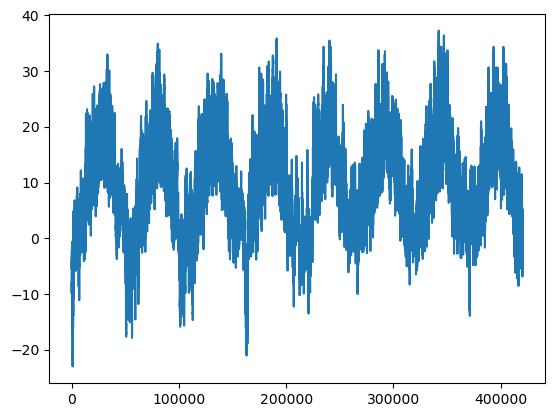

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**온도 시계열의 처음 10일 온도 그리기**

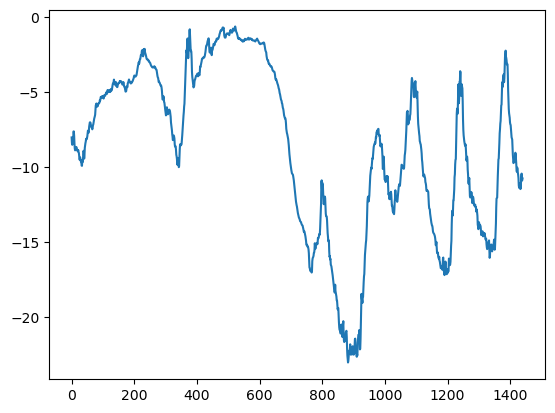

In [5]:
plt.plot(range(1440), temperature[:1440])

**각 데이터 분할에 사용할 샘플 수 계산**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 데이터 준비

**데이터 정규화**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

Metal device set to: Apple M1 Pro
[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2022-11-16 18:51:09.066874: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-16 18:51:09.067002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-16 18:51:09.148860: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


**훈련, 검증 및 테스트 데이터셋 인스턴스화**

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**데이터셋 중 하나의 출력 검사**

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### 기계 학습이 아닌 상식적인 기준선

**MAE 상식적인 기준선 MAE 계산**

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### 기본 기계-학습 모델을 시작해 보자

**밀집 연결 모델을 훈련하고 평가**

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2022-11-16 18:54:37.798384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 12.0379 - mae: 2.6884

2022-11-16 18:54:46.787183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 13s 13ms/step - loss: 12.0379 - mae: 2.6884 - val_loss: 10.9681 - val_mae: 2.6117
Epoch 2/10
819/819 [==============================] - 11s 13ms/step - loss: 8.9926 - mae: 2.3574 - val_loss: 12.2615 - val_mae: 2.7832
Epoch 3/10
819/819 [==============================] - 10s 13ms/step - loss: 8.3105 - mae: 2.2683 - val_loss: 11.0457 - val_mae: 2.6270
Epoch 4/10
819/819 [==============================] - 11s 13ms/step - loss: 7.8807 - mae: 2.2112 - val_loss: 10.2730 - val_mae: 2.5339
Epoch 5/10
819/819 [==============================] - 11s 13ms/step - loss: 7.5313 - mae: 2.1633 - val_loss: 13.0180 - val_mae: 2.8670
Epoch 6/10
819/819 [==============================] - 11s 13ms/step - loss: 7.2883 - mae: 2.1296 - val_loss: 11.0368 - val_mae: 2.6180
Epoch 7/10
819/819 [==============================] - 11s 13ms/step - loss: 7.1052 - mae: 2.1034 - val_loss: 11.3066 - val_mae: 2.6683
Epoch 8/10
819/819 [==============================] - 11s 13ms/st

2022-11-16 18:56:35.752382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 3s 8ms/step - loss: 11.2648 - mae: 2.6392
Test MAE: 2.64


**결과 그리기**

In [0]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 1D 합성곱 모델을 시작해 보자

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2022-11-16 21:09:47.486153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 22.9178 - mae: 3.7562

2022-11-16 21:09:59.802693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 16s 18ms/step - loss: 22.9178 - mae: 3.7562 - val_loss: 18.3476 - val_mae: 3.3547
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 15.9516 - mae: 3.1800 - val_loss: 17.5033 - val_mae: 3.3452
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 14.5686 - mae: 3.0325 - val_loss: 14.5721 - val_mae: 3.0236
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 13.4439 - mae: 2.9065 - val_loss: 18.1668 - val_mae: 3.3876
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 12.5988 - mae: 2.8060 - val_loss: 14.5969 - val_mae: 2.9981
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 11.9962 - mae: 2.7362 - val_loss: 14.1085 - val_mae: 2.9473
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 11.6041 - mae: 2.6886 - val_loss: 13.8157 - val_mae: 2.9107
Epoch 8/10
819/819 [==============================] - 15s 1

2022-11-16 21:12:15.442941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 4s 10ms/step - loss: 15.4820 - mae: 3.0974
Test MAE: 3.10


### 첫 번째 순환 기준선

**간단한 LSTM(Long Short-Term Memory)-기준 모델**

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


2022-11-16 21:24:20.694468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 21:24:20.855907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 21:24:22.032778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 44.1921 - mae: 4.8580

2022-11-16 21:24:49.608063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 21:24:49.715721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 38s 43ms/step - loss: 44.1921 - mae: 4.8580 - val_loss: 13.0769 - val_mae: 2.7349
Epoch 2/10
819/819 [==============================] - 34s 41ms/step - loss: 11.0130 - mae: 2.5655 - val_loss: 9.6099 - val_mae: 2.4226
Epoch 3/10
819/819 [==============================] - 34s 42ms/step - loss: 9.7937 - mae: 2.4313 - val_loss: 9.2078 - val_mae: 2.3652
Epoch 4/10
819/819 [==============================] - 34s 42ms/step - loss: 9.3609 - mae: 2.3818 - val_loss: 9.2554 - val_mae: 2.3683
Epoch 5/10
819/819 [==============================] - 35s 42ms/step - loss: 9.1577 - mae: 2.3535 - val_loss: 9.2680 - val_mae: 2.3664
Epoch 6/10
819/819 [==============================] - 35s 42ms/step - loss: 8.9018 - mae: 2.3196 - val_loss: 10.3553 - val_mae: 2.4278
Epoch 7/10
819/819 [==============================] - 35s 42ms/step - loss: 8.7117 - mae: 2.2964 - val_loss: 9.5650 - val_mae: 2.3876
Epoch 8/10
819/819 [==============================] - 35s 42ms/step -

2022-11-16 21:30:08.794366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 21:30:08.898364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


405/405 [==============================] - 9s 20ms/step - loss: 10.6158 - mae: 2.5611
Test MAE: 2.56


## 순환 신경망(Recurrent Neural Networks, RNN) 이해

**간단한 순환 신경망 넘파이(NumPy) 구현**

In [0]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [0]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [0]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

**An RNN layer that returns its full output sequence**

In [0]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

**Stacking RNN layers**

In [0]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## 고급 순환 신경망 사용

### 과대적합을 극복하기 위해 순환 드롭아웃(recurrent dropout) 사용

**드롭아웃-규제된 LSTM 훈련과 평가** (처리 속도가 늦다. 불가능 ...)

옮긴이: 
CUDNN has functionality to specifically accelerate LSTM and GRU layers. 
These GRU/LSTM layers can only be accelerated if they meet a certain criteria. 
In your case the problem is that you are using the LeakyReLU activation. 
The CUDNN LSTM acceleration only works if the activation is tanh.

Quoting from the documentation (https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

The requirements to use the cuDNN implementation are:

activation == tanh
recurrent_activation == sigmoid
recurrent_dropout == 0
unroll is False
use_bias is True
Inputs, if use masking, are strictly right-padded.
Eager execution is enabled in the outermost context.
Your LSTM should still run on the gpu but it will be constructed using scan and matmul operations and therefore be much slower. From my experience the CUDNN LSTM/GRU acceleration works so well that both these layers run faster then the SimpleRNN layer (which is not accelerated by CUDNN) despite this layer being much simpler.

옮긴이: 
said about RNN runtime performance in his book Deep Learning with Python 2nd edition

Recurrent models with very few parameters, like the ones in this chapter, tend to be significantly faster on a multicore CPU than on GPU, because they only involve small matrix multiplications, and the chain of multiplications is not well parallelizable due to the presence of a for loop. But larger RNNs can greatly benefit from a GPU runtime.

When using a Keras LSTM or GRU layer on GPU with default keyword arguments, your layer will be leveraging a cuDNN kernel, a highly optimized, low-level, NVIDIA-provided implementation of the underlying algorithm. As usual, cuDNN kernels are a mixed blessing: they’re fast, but inflexible—if you try to do anything not supported by the default kernel, you will suffer a dramatic slow- down, which more or less forces you to stick to what NVIDIA happens to provide. For instance, recurrent dropout isn’t supported by the LSTM and GRU cuDNN kernels, so adding it to your layers forces the runtime to fall back to the regular TensorFlow implementation, which is generally two to five times slower on GPU (even though its computational cost is the same).

As a way to speed up your RNN layer when you can’t use cuDNN, you can try unrolling it. Unrolling a for loop consists of removing the loop and simply inlining its content N times. In the case of the for loop of an RNN, unrolling can help TensorFlow optimize the underlying computation graph. However, it will also considerably increase the memory consumption of your RNN—as such, it’s only viable for relatively small sequences (around 100 steps or fewer). Also, note that you can only do this if the number of timesteps in the data is known in advance by the model (that is to say, if you pass a shape without any None entries to your initial Input()). It works like this:

    inputs = keras.Input(shape=(sequence_length, num_features))
    x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

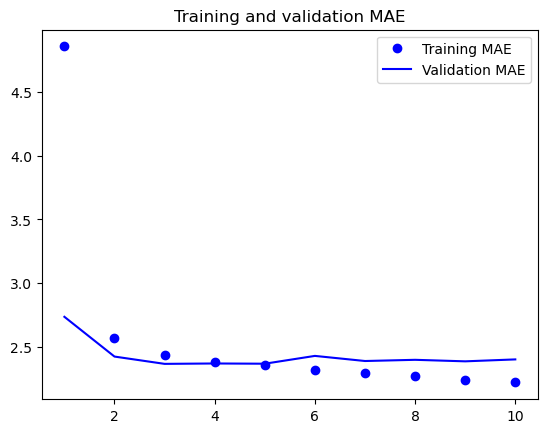

In [21]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### 스태킹(Stacking) 순환 층

**드롭아웃-규제, 스태킹을 적용한 GRU 모델 훈련과 평가** (처리 속도가 늦다. 불가능 ...)

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=1, # 50, 처리 속도가 늦다
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### 양방향 RNN 사용

**LSTM 양방향 LSTM 훈련과 평가**

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10


2022-11-16 22:05:44.359683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:05:44.596467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:05:44.610454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:05:44.927334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:05:44.942524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - ETA: 0s - loss: 23.6498 - mae: 3.5210

2022-11-16 22:06:31.921681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:06:32.049257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-16 22:06:32.049304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


819/819 [==============================] - 63s 74ms/step - loss: 23.6498 - mae: 3.5210 - val_loss: 10.6620 - val_mae: 2.5335
Epoch 2/10
819/819 [==============================] - 58s 70ms/step - loss: 9.5090 - mae: 2.4149 - val_loss: 9.8537 - val_mae: 2.4383
Epoch 3/10
819/819 [==============================] - 58s 71ms/step - loss: 8.7392 - mae: 2.3066 - val_loss: 9.6742 - val_mae: 2.4130
Epoch 4/10
819/819 [==============================] - 58s 71ms/step - loss: 8.1830 - mae: 2.2280 - val_loss: 9.8580 - val_mae: 2.4404
Epoch 5/10
819/819 [==============================] - 58s 71ms/step - loss: 7.7668 - mae: 2.1722 - val_loss: 10.0383 - val_mae: 2.4607
Epoch 6/10
819/819 [==============================] - 58s 70ms/step - loss: 7.4452 - mae: 2.1292 - val_loss: 9.9925 - val_mae: 2.4436
Epoch 7/10
819/819 [==============================] - 58s 70ms/step - loss: 7.1683 - mae: 2.0887 - val_loss: 10.2254 - val_mae: 2.4979
Epoch 8/10
819/819 [==============================] - 58s 70ms/step -

### 앞으로 나아가기

## 요약